# Multiple Important Sampling with One-Sample Model

The one-sample model draws a single sample from one of the available sampling strategies (e.g., light sampling or BRDF sampling) and weights its contribution using the balance heuristic.

One-sample model: $ \hat F = { w(x) f(x) \over c_i p_i(x) } $ 

Balance heuristic: $ w(x) = { c_i p_i(x) \over \sum_k c_k p_k(x) } $

where:
- $ c_i $ is the probability for the $ i $ th sampling strategy.
- $ p_i $ is the pdf for the $ i $ th sampling strategy.
- $w_i$ is the weight function, in this case balance heuristic.

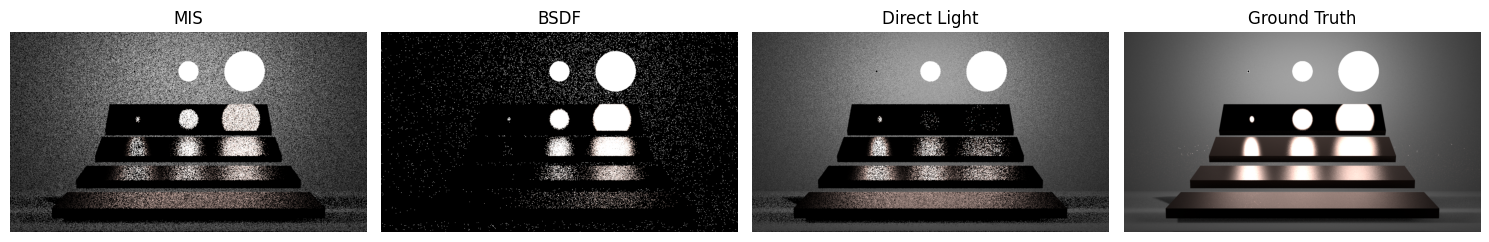

In [4]:
import mitsuba as mi
import drjit as dr
import matplotlib.pyplot as plt
from enum import Enum
mi.set_variant('llvm_ad_rgb')

class IntegratorMode(Enum):
    Mis = 0
    Bsdf = 1
    DirectLight = 2

class MISIntegrator(mi.SamplingIntegrator):
    def __init__(self, props):
        super().__init__(props)
        self.mode = props.get('mode', IntegratorMode.Mis.value )

    def sample(self, scene, sampler, ray, medium, active):

        si = scene.ray_intersect(ray, active)
        result = mi.Spectrum(0.0)
        active &= si.is_valid()

        # Add contribution from directly hitting an emitter
        emitter_value = si.emitter(scene, active).eval(si, active)
        result[active] += emitter_value
        active = dr.select(dr.sum(emitter_value) > 0, False, active)
        
        # MIS strategy selection probabilities for direct light and bsdf sampling. Have to sum to 1.
        c_light = 1/2
        c_bsdf = 1/2

        if dr.any(active):

            sample_mask : mi.Bool
            if self.mode == IntegratorMode.Mis.value:
                sample_mask = sampler.next_1d() < c_light
            elif self.mode == IntegratorMode.Bsdf.value:
                sample_mask = dr.zeros(dtype=mi.Bool, shape=active.shape)
            elif self.mode == IntegratorMode.DirectLight.value:
                sample_mask = dr.ones(dtype=mi.Bool, shape=active.shape)

            # Direct Light Sampling Strategy
            mask = sample_mask & active
            if dr.any(mask):
                light_sample, emitter_value = scene.sample_emitter_direction(si, sampler.next_2d(), True, mask)
                emitter_value *= light_sample.pdf # Remove the pdf term from the emitter's sampling as it's going to be combined manually using MIS
                mask &= light_sample.pdf > 0

                bsdf_value, bsdf_pdf = si.bsdf().eval_pdf(mi.BSDFContext(), si, si.to_local(light_sample.d), mask)

                w : mi.Float
                if self.mode == IntegratorMode.Mis.value:
                    # The balance heuristic for given sample direction
                    w = 1 / (light_sample.pdf * c_light + bsdf_pdf * c_bsdf)
                else:
                    # If we are not using MIS, we just use the pdf of the light sample
                    w = 1 / light_sample.pdf

                result[mask] += w * emitter_value * bsdf_value

            # BSDF Sampling Strategy
            mask = ~sample_mask & active
            if dr.any(mask):
                bsdf_sample, bsdf_value = si.bsdf().sample(mi.BSDFContext(), si, sampler.next_1d(), sampler.next_2d(), mask)
                bsdf_value *= bsdf_sample.pdf # Remove the pdf from the bsdf's value as it's going to be combined manually using MIS
                mask &= bsdf_sample.pdf > 0

                bsdf_ray = si.spawn_ray( si.to_world(bsdf_sample.wo) )
                light_test_interaction = scene.ray_intersect(bsdf_ray, mask)
                
                ds = mi.DirectionSample3f(scene, light_test_interaction, si)
                emitter_value = light_test_interaction.emitter(scene).eval(light_test_interaction, mask)

                # Compute the pdf of the light's sample: (1 / # of emitters) * probability of the sample on the hit emitter
                light_pdf = scene.pdf_emitter_direction(si, ds, mask)

                w : mi.Float
                if self.mode == IntegratorMode.Mis.value:
                    # The balance heuristic for given sample direction
                    w = 1 / (bsdf_sample.pdf * c_bsdf + light_pdf * c_light)
                else:
                    # If we are not using MIS, we just use the pdf of the bsdf sample
                    w = 1 / bsdf_sample.pdf

                result[mask] += w * bsdf_value * emitter_value


        return (result, active, [])

mi.register_integrator("mis", lambda props: MISIntegrator(props))

scene = mi.load_file("scenes/veach-mis/scene.xml")
mis_integrator = mi.load_dict({ 'type': 'mis'
                              , 'mode' : IntegratorMode.Mis.value })
bsdf_integrator = mi.load_dict({ 'type': 'mis'
                              , 'mode' : IntegratorMode.Bsdf.value })
light_integrator = mi.load_dict({ 'type': 'mis'
                              , 'mode' : IntegratorMode.DirectLight.value })

mis_image = mi.render(scene, integrator=mis_integrator, spp=1)
bsdf_image = mi.render(scene, integrator=bsdf_integrator, spp=1)
light_image = mi.render(scene, integrator=light_integrator, spp=1)
gt_image = mi.render(scene, spp=128)

images = [mis_image, bsdf_image, light_image, gt_image]
titles = ['MIS', 'BSDF', 'Direct Light', 'Ground Truth']

plt.figure(figsize=(15, 5))
for i, (img, title) in enumerate(zip(images, titles)):
    plt.subplot(1, len(images), i + 1)
    plt.imshow(mi.util.convert_to_bitmap(img))
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()

Notes:
- BSDF sampling struggles for small light sources with rough materials, because the scattered directions rarely hit the light.
- Direct light sampling struggles with specular surfaces, as the BRDF contributes significantly only near the mirror direction.
- MIS combines strategies, leveraging light sampling for small lights and BRDF sampling for smooth materials.
- Based on [Eric Veach's thesis](https://graphics.stanford.edu/courses/cs348b-03/papers/veach-chapter9.pdf), *the balance heuristic* is the best weight function for the one-sample model as it minimizes the variance.

